# Анализ вакансий
**Часть7**
## Обработка вакансии

# 1. Служебный код
## 1.1. Импорт
### 1.1.1. Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from importlib import reload
import warnings

### 1.1.2. Импорт модулей

In [2]:
import config
reload(config)
from config import settings

import scripts.utils.files as files
reload(files)

import scripts.model_scripts.cluster_utils as cu
reload(cu)

import scripts.data_scripts.prepare_data as prep
reload(prep)

import scripts.model_scripts.text_process as proc
reload(proc)

from scripts.data_scripts import clear_text as cl
reload(cl)

<module 'scripts.data_scripts.clear_text' from '/mnt/data/projects/active/urfu/vkr/scripts/data_scripts/clear_text.py'>

## 1.2. Настройка параметров

In [3]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision",6)
sns.set_style("ticks",{'axes.grid' : True})
warnings.simplefilter("ignore")

#Для корректного отображения графиков в ноутбуках используется команда %matplotlib inline
%matplotlib inline
# для корректного отображения графиков на тёмном фоне
plt.style.use('default')
RANDOM_STATE = 123

In [4]:
MODEL_SUBDIR = settings.get_fresh('BLOCK_MODELING_SUBDIR')
PROCESSED_SUBDIR = settings.get_fresh('PROCESSED_LOCAL_SUBDIR')
READY_DATA_LOCAL_SUBDIR = settings.get_fresh('READY_DATA_LOCAL_SUBDIR')

FILENAME_TITLES_EXTRACTED_ED = settings.get_fresh('FILENAME_TITLES_EXTRACTED_ED')
FILENAME_BLOCK_VECTORIZATION_MODEL = settings.get_fresh('FILENAME_BLOCK_VECTORIZATION_MODEL')
FILENAME_BLOCK_CLASSIFICATION_MODEL=settings.get_fresh('FILENAME_BLOCK_CLASSIFICATION_MODEL')
FILENAME_REQUIREMENT_VECTORIZATION_MODEL = settings.get_fresh('FILENAME_REQUIREMENT_VECTORIZATION_MODEL')
FILENAME_BLOCK_REDUCER_MODEL = settings.get_fresh('FILENAME_BLOCK_REDUCER_MODEL')

FILENAME_ALL_KEYWORD = settings.get_fresh('FILENAME_ALL_KEYWORD')
FILENAME_CLUSTER_KEYWORDS = settings.get_fresh('FILENAME_CLUSTER_KEYWORDS')
FILENAME_CLUSTER_DATA = settings.get_fresh('FILENAME_CLUSTER_DATA')


In [5]:
CLUSTERIZATION_MODEL_NAME='paraphrase_minilm_l12'
CLASSIFICATION_MODEL_NAME='paraphrase_mpnet_v2'

MODELS = {
    CLUSTERIZATION_MODEL_NAME:
              'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',

    CLASSIFICATION_MODEL_NAME:
              'sentence-transformers/paraphrase-multilingual-mpnet-base-v2',}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


# 2. Загрузка данных и моделей

In [ ]:
# Дополнительные модели
# df_titles = files.load_file(FILENAME_TITLES_EXTRACTED_ED, PROCESSED_SUBDIR,  to_decompress = False, with_dates = False)
# filename = f'{CLUSTERIZATION_MODEL_NAME}_{FILENAME_REQUIREMENT_VECTORIZATION_MODEL}'
# requirement_vectorization_model = files.load_model(filename)
# filename = f'{CLUSTERIZATION_MODEL_NAME}_{2}_{FILENAME_BLOCK_REDUCER_MODEL}'
# block_reducer_reducer = files.load_model(filename)

In [7]:
block_vectorization_filename = f'{CLASSIFICATION_MODEL_NAME}_{FILENAME_BLOCK_VECTORIZATION_MODEL}'
block_vectorization_model = files.load_model(block_vectorization_filename)
block_classification_model = files.load_model(FILENAME_BLOCK_CLASSIFICATION_MODEL)

In [8]:
filename=settings.get_fresh('FILENAME_ALL_KEYWORD')
all_keywords = files.load_file(filename,READY_DATA_LOCAL_SUBDIR, to_decompress = False, with_dates=False)

filename=settings.get_fresh('FILENAME_CLUSTER_KEYWORDS')
keywords=files.load_data_dump(filename,READY_DATA_LOCAL_SUBDIR)

filename=settings.get_fresh('FILENAME_CLUSTER_DATA')
cluster_data = files.load_file(filename,READY_DATA_LOCAL_SUBDIR, to_decompress=False, with_dates=False)

# 3. Тексты для обработки

In [18]:
v1='''
<p><strong>&quot;Трактородеталь Групп&quot;</strong> - крупная федеральная компания - лидер на рынке поставки лесозаготовительной, дорожно-строительной техники и запасных частей приглашает на работу <strong>Сервисного механика!</strong></p> <p>Уже сейчас у нас успешно работает более 50 филиалов и около 1000 сотрудников по Северо-Западному, Уральскому и Приволжскому округам. И это не предел! Мы активно расширяемся и укрепляем свои позиции, поэтому нам нужен специалист, который станет частью нашей успешной и сильной команды!</p> <p><strong>Обязанности:</strong></p> <ul> <li>Ремонт, техническое обслуживание лесозаготовительной и дорожно-строительной техники;</li> <li>Диагностика техники в полевых условиях (выезд на территорию клиента);</li> <li>Ведение сопутствующей технической документации.</li> </ul> <p><strong>Наши ожидания от кандидата:</strong></p> <ul> <li><strong>Опыт </strong>работы желателен, но <strong>необязателен. Всему научим!</strong></li> <li>Образование техническое;</li> <li>Обязательное наличие водительский прав категории В;</li> <li>Ответственность, аккуратность, внимание к деталям.</li> </ul> <p><strong>Условия и преимущества работы у нас:</strong></p> <ul> <li>Интересная работа в надежной перспективной компании федерального уровня;</li> <li>Высокая заработная плата (оклад + премии);</li> <li>Бесплатное корпоративное обучение за счет компании;</li> <li>Официальное оформление с первого дня работы;</li> <li>Перспективы профессионального и карьерного роста;</li> <li>Предоставляется служебный автомобиль.</li> <li>Дружный коллектив;</li> <li>Лояльное руководство</li> </ul>
'''

In [3]:
v2=''''<p><strong>Описание проекта:</strong></p>
<p>
    <strong>  Текущее состояние:  </strong>  <br  />
    Разработан регламент инцидент-менеджмента по качеству данных. Не внедрен для массового применения без организации выделенной 2ЛС по качеству данных (КД). 2ЛС по КД в банке не было. Выстраиваем с нуля.<br  />
    Реализован процесс регистрации и обработки инцидентов КД в ITSM системе Банка (SimpleOne).<br />
    Реализована  базовая отчетность по инцидентам и проблемам КД.<br />
    <strong>Ближайшие задачи:</strong><br />
    1. Стартовать прием и разбор инцидентов КД от потребителей данных в Банке.<br />
    2. Пропилотировать Регламент инцидент-менеджмента, сформировать требования по необходимой BI-отчетности.<br />
    3. Нарастить экспертизу по анализу причин инцидентов и выработать типовые подходы для диагностики на потоке.<br />
    4. Организовать контрль за метриками качества данных по DQ-проверкам<br />
    5. Организовать выставление BUG-ов в JIRA на команды Владельцев данных и контроль исполения<br /><br />
    2 чел во 2й линии сопровождения на старте: лидирующий дата-стюард + дата-стюард
</p>
<p>
    <strong>Обязанности:</strong>
</p>
<p>
    1. Лидер 2й линии сопровождения по инцидент-менеджменту и проблем-менеджменту качества данных.<br />
    2. Анализ зарегистрирвоанных инцидентов и выявление корневых причин. Маршрутизация инцидентов на 3ЛС владельцев данных.<br />
    3. Формирование &quot;Типовых карт решения инцидентов&quot; и наборов контрольных скриптов для повышения эффективности решения наиболее частых типов инцидентов.<br />
    4. Регистрация &quot;корневых проблем качества данных&quot; в ITSM Банка и соответствующих BUG-ов в JIRA владельцев данных. Контроль исполнения.<br />
    5. Формирование требований к BI-отчетности для мониторинга динамики инцидентов, метрик качества данных, наиболее проблемных зонах/продуктах/командах, контроля SLA и т.д.<br />
    6. Организация информирования групп потребителей и владельцев данных о сбоях в качестве данных.<br />
    7. Предложение по оптимизациям процессов с ПДН в Банке. Автоматизация процесса анализа инцидентов (готовые наборы контрольных скриптов и карты решения инцидентов).
</p>
<p>
    <strong>Требования:</strong>
</p>
<p> </p>
<p>
    1. OracleSQL (в перспективе GreenPlum) на уровне запуска скриптов от 3ЛС и интерпретации результатов для первичной диагностики<br />
    2. Построение системы контроля за инцидент- и проблем-менеджментом по Качеству данных, включая аналитическую отчетность и систематизаицю корневых проблем.<br />
    3. Ведение реестра системных проблем с качеством данных, регулярная отчетность по штрафникам на ТОП-менеджмент.​​​​​​​
</p>
<p>
    <strong>Условия:</strong>​​​​​​​<strong>​​​​​​​</strong>
</p>
<p>
    В МТС Финтех вас ждет культура творчества и экспериментов: мы всегда ищем новые решения, задаем тренды и не боимся быть не похожими. А еще:
</p>
<ul>
    <li>​​​​Программа ДМС со стоматологией, сессиями с психологом и госпитализацией, страхование от несчастных случаев и болезней 24/7 и страхование выезжающих за рубеж. К ДМС можно подключить детей и родственников. А еще доступ к телемедицине BestDoctor</li>
    <li> <p>Корпоративна мобильную связь и интернет для сотрудников;</p> </li>
    <li>Очное и онлайн-обучение в Корпоративном университете, доступ к онлайн-библиотеке с полезными книгами и периодикой;</li>
    <li>Пространство для неформального общения: творческие программы, интеллектуальные игры и турниры;</li>
</ul>
<ul>
    <li>На всякий случай в офисе работает врач, а для желающих мы периодически организуем вакцинацию – это удобно;</li>
    <li>Мы за спорт: вместе тренируемся в MTS Fintech Run Club, в офисе есть бесплатный тренажерный зал. Ты можешь присоединиться к корпоративным спортивным командам и занятиям йогой;</li>
    <li>Поддержка сотрудников: программа материальной помощи в различных жизненных ситуациях.</li>
</ul>
'''

In [10]:
v3='''
<p>Наша компания разрабатывает аналитические решения для различных индустрий: системы предсказания спроса на товары для оффлайн-ритейлов, рекомендательные системы в банках, поисковые системы по товарам для онлайн-ритейлеров и многое другое. Мы активно развиваемся как в России (среди клиентов Сбербанк, Пятёрочка, KFC, Перекрёсток, Альфа Банк, МВидео и др.), так и за рубежом. У нас молодой, дружный и опытный коллектив, многие сотрудники - выпускники МГУ, МФТИ, ВШЭ, Сколтеха, ШАД Яндекса, бывшие сотрудники Яндекса, Гугла, Самсунга, Тинькова, Рамблера (однако всё это, разумеется, не является ограничителем для кандидатов — мы смотрим на навыки, а не на регалии).</p> <p>Мы ищем Java Developer уровня middle и выше для усиления нашего направления разработки внутреннего фреймворка, позволяющего сокращать затраты на разработку проектов и вести их более стандартизировано.<br />Это работа, которая потребует максимального совмещения технической экспертизы и творческого мышления, надо постоянно думать о том, как сделать работу других разработчиков проще и приятнее.<br />Помимо участия в разработке ядра фреймворка, мы предлагаем периодическое привлечение к разработке других проектов по принципу ротации - важно непосредственно на себе проверять то, насколько удобным получается фреймворк, приносить в команду идеи по дальнейшему улучшению.</p> <p><strong>Задачи</strong>:</p> <ul> <li>Разработка внутренних инструментов для разработчиков компании (фреймворк);</li> <li>Участие в проектировании решений и выборе подходов/технологий;</li> <li>Увеличение покрытия разрабатываемых решений тестами;</li> <li>Поддержка и консультации по использованию фреймворка другим разработчикам;</li> <li>Участие в проектах в качестве лида проекта от команды фреймворка.</li> </ul> <p><strong>Требования:</strong></p> <ul> <li>Опыт разработки на Java/Kotlin от 2-х лет;</li> <li>Уверенное понимание принципов Spring Framework;</li> <li>Опыт проектирования и разработки Rest API;</li> <li>Понимание принципов ООП;</li> <li>Уверенное знание SQL;</li> <li>Опыт работы с Docker и k8s.</li> </ul> <p><strong>Будет большим плюсом:</strong></p> <ul> <li>Опыт работы с Kafka/RabbitMQ/Clickhouse/Redis.</li> </ul> <p><strong>У нас:</strong></p> <ul> <li>Участие в быстром росте компании, работающей на перспективном AI рынке;</li> <li> <p>Удаленная работа при желании;</p> </li> <li>Поддержка кандидата в профессиональном и карьерном росте;</li> <li>Совместная работа с опытными разработчиками, аналитиками данных, менеджерами, продуктологами;</li> <li>Гибкий график работы;</li> <li>Оформление полностью белое по ТК РФ;</li> <li>ДМС (включая стоматологию);</li> <li>Уютный офис в центре Москвы (2 минуты от м. Сухаревская) со всем необходимым для комфортной работы.</li> </ul>
'''

In [5]:
v4='''
<p><strong>НЕОСОФТ </strong>– это российская ИТ-компания, специализирующаяся на разработке программного обеспечения в сфере E-Commerce.</p> <p><strong>Мы являемся</strong> основным исполнителем работ по разработке новой платформы для уже существующего маркетплейса федерального масштаба и нам нужно больше светлых голов и горящих сердец.</p> <p>Первая версия продукта появилась в <strong>2009 году</strong>. С тех пор мы постоянно обновляем его в тесной кооперации с нашими пользователями, будучи на передовой отраслевого рынка. В настоящий момент у нас на сайте 30 тысяч постоянных пользователей, 5000 заказов ежедневно.</p> <p>Компания открыта для целеустремленных людей, которые стремятся к новым знаниям, постоянному развитию и не избегают сложных задач!</p> <p>У нас <strong>работает команда профессионалов</strong> по направлениям: разработки, аналитики, тестирования, внедрения и техподдержки.</p> <p>Сейчас мы в поиске <strong>Middle Backend-разработчика </strong>с опытом разработки на Node.js.</p> <p><strong>Чем придется заниматься:</strong></p> <ul> <li>Асинхронный, синхронный JS/TS</li> <li>Оптимизация работы с большими объёмами данных</li> <li>Разработка ведется на typescript (потому обязательно готовность его освоить)</li> </ul> <p><strong>Мы готовы рассмотреть кандидатов со знаниями следующих технологий:</strong></p> <p><strong>C#, C++, Java, Python, PHP</strong></p> <p><strong>Для нас важны знания технологий:</strong></p> <ul> <li>Node.js</li> <li>JavaScript</li> <li>TypeScript</li> <li>SQL (MySQL/Postgresql)</li> <li>Git</li> <li>RabbitMQ</li> <li>ClickHouse</li> <li> <p>Redis</p> </li> <li> <p>Sphinx</p> </li> </ul> <p><strong>Важен опыт:</strong></p> <ul> <li>Работы с большими объёмами данных</li> <li>Проектирование крупных проектов</li> <li>Работы в e-commers</li> <li>Работы с параллельными вычислениями</li> <li>Внедрения аналитики</li> </ul> <ul> </ul> <p><strong>Условия труда:</strong></p> <ul> <li>Работа в просторном комфортном офисе в центре города (5 минут от ст. метро Алабинская)</li> <li>Современное оборудованное рабочее место</li> <li>Работа в коллективе профессионалов, дружественная атмосфера, без бюрократии</li> <li>Интересные задачи и проект</li> <li>Оформление по ТК РФ</li> <li>Возможность выбрать график работы</li> </ul> <p><strong>Почему стоит работать у нас?</strong></p> <ul> <li>Прокачаешь свои скиллы в разработке веб-сервисов на Node.js</li> <li>Возможность обоснованно влиять на стратегические планы и используемые технологии (работа с владельцами напрямую)</li> <li>У нас действительно много сложных, интересных и масштабных задач</li> </ul> <p><strong>Заинтересовало? Откликнись на вакансию!</strong></p>'''

In [ ]:
v5='''
<p><strong>КОРУС Консалтинг</strong> – одна из крупнейших консалтинговых ИТ-компании и компаний-интеграторов в России. Нас уже более 1000 человек, и мы продолжаем расти на протяжении уже 20 лет.</p> <p>Наша география тоже расширяется: Санкт-Петербург, Москва, Ярославль и другие уголки России.</p> <p>Сейчас мы в поиске коллеги <strong>Системного аналитика, на такие проекты, как построение хранилищ данных, отчетности и управление качеством данных, </strong>в департамент аналитических решений. Мы хотим, чтобы специалист стал центром экспертизы и участвовал в развитии практики.</p> <p><strong>Команда</strong> департамента аналитических решений занимается всеми современные направлениями в области работы с данными: внедрением BI-систем и систем аналитической отчетности, проектированием сложных хранилищ и витрин данных, разработками в области продвинутой аналитики и больших данных, применением прикладных продуктов и сервисов с использованием машинного обучения, адаптацией и внедрением решений в области управлениям данными <em>(Data Governance, Data Quality)</em>, разработкой методологии и стратегии работы с данными.</p> <p><strong>Наши проекты:</strong> Мы работаем над амбициозными задачами в самых крупных стратегических проектах, затрагивающих изменение всего технологического ландшафта наших заказчиков. На рынке - единицы проектов подобного уровня, сочетающих в себе как использование инновационных технологических решений, сложные многоуровневые архитектуры, высокую экспертизу всех участников, так и дружественный формат взаимодействия и построения команды.</p> <p><strong>Основной стек технологий, встречающийся на наших проектах:</strong></p> <ul> <li>Классические хранилища: Oracle, PostgreSQL/GreenPlum;</li> <li>Стек Apache: Hadoop, AirFlow, Nifi, Kafka;</li> <li>Системы отчетности: Qlik, Luxms BI.</li> </ul> <p><strong>Что нужно делать:</strong></p> <ul> <li>взаимодействовать с бизнес-аналитиками команды и архитектором для формирования ТЗ и постановок на разработку;</li> <li>разрабатывать логические модели данных совместно с архитектором и бизнес-аналитиком;</li> <li>проводить анализ источников данных, разработку спецификаций на интеграционное взаимодействие;</li> <li>на основе логических моделей данных и описаний источников формировать требования по сбору данных и расчету требуемых показателей;</li> <li>взаимодействовать с командой разработки для контроля разработки по подготовленным ТЗ и постановкам;</li> <li>участвовать в разработке проектной и эксплуатационной документации;</li> <li>участвовать в тестировании разработанного функционала;</li> <li>участвовать в процессах сверки данных (верификация качества данных);</li> <li>участвовать в поддержке системы в опытной и постоянной эксплуатации;</li> <li>тесно взаимодействовать со всей командой.</li> </ul> <strong>Ждем от вас:</strong> <ul> <li>опыт взаимодействия с командой разработки;</li> <li>опыт работы с реляционными БД (SQL) для формирования постановок разработчикам – написание SQL-запросов;</li> <li>опыт работы с функциональными требования для формирования ТЗ;</li> <li>опыт подготовки проектной документации (технические задания на разработку, операционные инструкции и т.д.)</li> <li>знание принципов разработки ПО, проектирования приложений в части БД (плюсом будет навык работы с системами проектирования логических/физичеcких моделей данных, например, SAP Power Designer).</li> </ul> <strong>Успешному кандидату готовы предложить:</strong> <ul> <li>В вопросах компенсации ориентируемся на предложение кандидата: знаем рынок, но не хотим ставить ограничений;</li> <li>Интересные и сложные задачи, крупные проекты;</li> <li>Постоянный профессиональный и личный рост, самостоятельность в работе. У нас нет бюрократии и бесконечных отчетов, а совещания только по необходимости и с четкой программой. Поощряем любое развитие во всех направлениях;</li> <li>Участие в корпоративных образовательных и социальных программах: заботитесь об окружающей среде, помогаете людям в сложной ситуации, занимаетесь спортом? Можете принять участие в любых активностях.</li> <li>Гибкий рабочий график (нет фиксированного времени присутствия в офисе), возможность удаленной работы, 100% отдых на выходные и праздничные дни, корпоративные мероприятия для отдыха в т.ч. с выездом в другие города.</li> <li>Оформление в штат компании, согласно ТК РФ, “белая” заработная плата, ДМС и все остальные стандартные бенефиты.</li> </ul> <p><em>У нас есть возможность проявить себя и получить бесценный опыт на реальных комплексных аналитических проектах в работе с крупнейшими заказчиками своих областей. Присоединяйтесь.</em></p>
'''

# 4.Обработка текста вакансии

Текст для обработки

In [11]:
text=v3

## 4.1. Извлечение текстовых блоков из описания вакансии

In [12]:
item = cl.preprocess_description(text)
content_dict = {}
start_index=0
index = prep.parse_description(0, item, content_dict, start_index)

Результат разбиения на блоки:

In [13]:
for key in content_dict:
    print(f'Раздел: {key}')
    for field in content_dict[key]:
        print(f'[{field}]')
        print(content_dict[key][field])
        print("_"*68)

Раздел: 1
[id]
0
____________________________________________________________________
[title]

____________________________________________________________________
[content]
Наша компания разрабатывает аналитические решения для различных индустрий: системы предсказания спроса на товары для оффлайн-ритейлов, рекомендательные системы в банках, поисковые системы по товарам для онлайн-ритейлеров и многое другое. Мы активно развиваемся как в России (среди клиентов Сбербанк, Пятёрочка, KFC, Перекрёсток, Альфа Банк, МВидео и др.), так и за рубежом. У нас молодой, дружный и опытный коллектив, многие сотрудники - выпускники МГУ, МФТИ, ВШЭ, Сколтеха, ШАД Яндекса, бывшие сотрудники Яндекса, Гугла, Самсунга, Тинькова, Рамблера (однако всё это, разумеется, не является ограничителем для кандидатов — мы смотрим на навыки, а не на регалии
____________________________________________________________________
[content_type]
0
____________________________________________________________________
[semantic_

Подготовка датасета для дальнейшей работы с ним:

In [14]:
df = pd.DataFrame.from_dict(content_dict, "index")
df['id'] = pd.to_numeric(df['id'], downcast='unsigned')
df['content_type'] = pd.to_numeric(df['content_type'], downcast='unsigned')
df['semantic_type'] = pd.to_numeric(df['semantic_type'], downcast='unsigned')
df.reset_index(drop=True,inplace=True, )
df

,id,title,content,content_type,semantic_type,block_id
0,0,,Наша компания разрабатывает аналитические реше...,0,0,1
1,0,,Мы ищем Java Developer уровня middle и выше дл...,2,0,2
2,0,Задачи,Разработка внутренних инструментов для разрабо...,1,0,4
3,0,Требования,Опыт разработки на Java/Kotlin от 2-х лет;\nУв...,1,0,6
4,0,Будет большим плюсом,Опыт работы с Kafka/RabbitMQ/Clickhouse/Redis,1,0,8
5,0,У нас,"Участие в быстром росте компании, работающей н...",1,0,10


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             6 non-null      uint8 
 1   title          6 non-null      object
 2   content        6 non-null      object
 3   content_type   6 non-null      uint8 
 4   semantic_type  6 non-null      uint8 
 5   block_id       6 non-null      int64 
dtypes: int64(1), object(2), uint8(3)
memory usage: 290.0+ bytes


## 4.2. Классификация текстовых блоков объявлений
### 4.2.1 Подготовка данных к классификации

In [16]:
mapper={0:0, 1:0, 2:1,3:1,4:1,5:2}
df_cl=df.copy()
df_cl['target_type'] = pd.to_numeric(df_cl['semantic_type'].map(mapper), downcast='unsigned')
df_cl.drop(columns=['semantic_type', 'content_type', 'id'], inplace=True, errors='ignore')
df_cl

,title,content,block_id,target_type
0,,Наша компания разрабатывает аналитические реше...,1,0
1,,Мы ищем Java Developer уровня middle и выше дл...,2,0
2,Задачи,Разработка внутренних инструментов для разрабо...,4,0
3,Требования,Опыт разработки на Java/Kotlin от 2-х лет;\nУв...,6,0
4,Будет большим плюсом,Опыт работы с Kafka/RabbitMQ/Clickhouse/Redis,8,0
5,У нас,"Участие в быстром росте компании, работающей н...",10,0


In [17]:
proc.tokenize_blocks(df_cl)

Процесс 52414 начал свою работу
Процесс 52414 закончил свою работу


,title,content,block_id,target_type,tokenized_block
0,,Наша компания разрабатывает аналитические реше...,1,0,наш компания разрабатывать аналитический решен...
1,,Мы ищем Java Developer уровня middle и выше дл...,2,0,мы искать java developer уровень middle и выше...
2,Задачи,Разработка внутренних инструментов для разрабо...,4,0,задача.разработка внутренний инструмент для ра...
3,Требования,Опыт разработки на Java/Kotlin от 2-х лет;\nУв...,6,0,требование.опыт разработка на javakotlin от 2 ...
4,Будет большим плюсом,Опыт работы с Kafka/RabbitMQ/Clickhouse/Redis,8,0,быть больший плюс.опыт работа с kafkarabbitmqc...
5,У нас,"Участие в быстром росте компании, работающей н...",10,0,у мы.участие в быстрый рост компания работать ...


In [18]:
df_cl['raw_block']=df_cl.title
df_cl.raw_block.fillna("",inplace=True)
df_cl['raw_block']=df_cl.raw_block.str.lower()+'. ' + df_cl.content.str.lower()
df_cl

,title,content,block_id,target_type,tokenized_block,raw_block
0,,Наша компания разрабатывает аналитические реше...,1,0,наш компания разрабатывать аналитический решен...,. наша компания разрабатывает аналитические ре...
1,,Мы ищем Java Developer уровня middle и выше дл...,2,0,мы искать java developer уровень middle и выше...,. мы ищем java developer уровня middle и выше ...
2,Задачи,Разработка внутренних инструментов для разрабо...,4,0,задача.разработка внутренний инструмент для ра...,задачи. разработка внутренних инструментов для...
3,Требования,Опыт разработки на Java/Kotlin от 2-х лет;\nУв...,6,0,требование.опыт разработка на javakotlin от 2 ...,требования. опыт разработки на java/kotlin от ...
4,Будет большим плюсом,Опыт работы с Kafka/RabbitMQ/Clickhouse/Redis,8,0,быть больший плюс.опыт работа с kafkarabbitmqc...,будет большим плюсом. опыт работы с kafka/rabb...
5,У нас,"Участие в быстром росте компании, работающей н...",10,0,у мы.участие в быстрый рост компания работать ...,"у нас. участие в быстром росте компании, работ..."


In [19]:
df_cl.drop(columns=['title', 'content'], inplace=True, errors='ignore')

### 4.2.2.. Векторизация текста

In [20]:
embeddings = block_vectorization_model.encode(df_cl.tokenized_block, device=DEVICE)
embeddings

array([[ 0.13397416, -0.01274368, -0.00902894, ...,  0.07745592,
        -0.08188037, -0.0847577 ],
       [ 0.09001043, -0.02912145, -0.01391603, ...,  0.01138796,
        -0.00110879, -0.0009192 ],
       [-0.02691716,  0.00261021, -0.01590128, ...,  0.06635792,
        -0.03910174, -0.01304474],
       [-0.04216908,  0.19391331, -0.01059906, ...,  0.02760887,
        -0.02173988, -0.02393916],
       [ 0.00811421,  0.06134134, -0.01682335, ...,  0.04339951,
         0.04302054, -0.03602411],
       [ 0.01766093,  0.0699883 , -0.018635  , ...,  0.04524244,
        -0.04673801, -0.0880142 ]], dtype=float32)

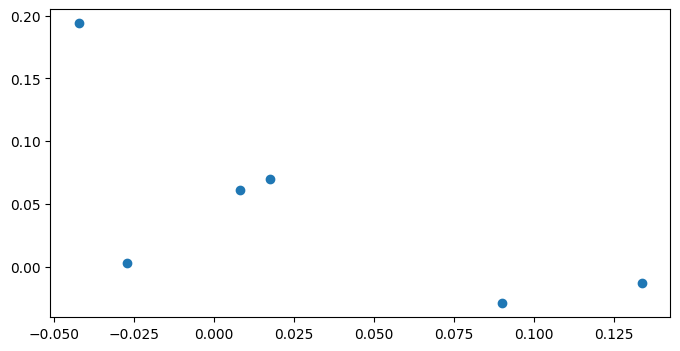

In [21]:
plt.figure(figsize=(8,4))
plt.scatter(embeddings[:,0], embeddings[:,1])

In [22]:
df_cl['target_type'] = block_classification_model.predict(embeddings)

In [23]:
df_cl

,block_id,target_type,tokenized_block,raw_block
0,1,0,наш компания разрабатывать аналитический решен...,. наша компания разрабатывает аналитические ре...
1,2,0,мы искать java developer уровень middle и выше...,. мы ищем java developer уровня middle и выше ...
2,4,1,задача.разработка внутренний инструмент для ра...,задачи. разработка внутренних инструментов для...
3,6,1,требование.опыт разработка на javakotlin от 2 ...,требования. опыт разработки на java/kotlin от ...
4,8,1,быть больший плюс.опыт работа с kafkarabbitmqc...,будет большим плюсом. опыт работы с kafka/rabb...
5,10,0,у мы.участие в быстрый рост компания работать ...,"у нас. участие в быстром росте компании, работ..."


Блоки, имеющие класс 1, будут использоваться для извлечения требований:

In [63]:
indexes=df_cl[df_cl.target_type ==1].index.tolist()
indexes

[2, 3, 4]

In [64]:
df_selected=df.loc[indexes, :]
df_selected

,id,title,content,content_type,semantic_type,block_id
2,0,Задачи,Разработка внутренних инструментов для разрабо...,1,0,4
3,0,Требования,Опыт разработки на Java/Kotlin от 2-х лет;\nУв...,1,0,6
4,0,Будет большим плюсом,Опыт работы с Kafka/RabbitMQ/Clickhouse/Redis,1,0,8


Проставляем семантический тип блока в исходный словарь

In [61]:
for key in content_dict:
    block_id=content_dict[key]['block_id']
    if len(df_cl[df_cl.block_id == block_id])>0:
        content_dict[key]['semantic_type'] =  list(df_cl[df_cl.block_id == block_id].target_type)[0]

## 4.3. Извлечение требований

In [65]:
list_items = proc.parse_requirements(df_selected)

In [28]:
list_items

,id,block_id,semantic_type,list_item
1,0,4,0,Разработка внутренних инструментов для разрабо...
2,0,4,0,Участие в проектировании решений
3,0,4,0,выборе подходов
4,0,4,0,технологий
5,0,4,0,Увеличение покрытия разрабатываемых решений те...
...,...,...,...,...
17,0,6,0,k8s
18,0,8,0,Опыт работы с Kafka
19,0,8,0,RabbitMQ
20,0,8,0,Clickhouse


In [66]:
requirements_dict = proc.tokenize_requirement_dataset(list_items)

Процесс 52414 начал свою работу
Процесс 52414 закончил свою работу


In [67]:
list_items_tok = pd.DataFrame.from_dict(requirements_dict, "index")
list_items_tok

,count,canonical,unigrams,bigrams,trigrams
разработка_внутренний_инструмент_разработчик_компания_фреймворк,1,Разработка внутренних инструментов для разрабо...,"[разработка, внутренний, инструмент, разработч...","[(разработка, внутренний), (внутренний, инстру...","[(разработка, внутренний, инструмент), (внутре..."
участие_проектирование_решение,1,Участие в проектировании решений,"[участие, проектирование, решение]","[(участие, проектирование), (проектирование, р...","[(участие, проектирование, решение)]"
выбор_подход,1,выборе подходов,"[выбор, подход]","[(выбор, подход)]",[]
технология,1,технологий,[технология],[],[]
увеличение_покрытие_разрабатывать_решение_тест,1,Увеличение покрытия разрабатываемых решений те...,"[увеличение, покрытие, разрабатывать, решение,...","[(увеличение, покрытие), (покрытие, разрабатыв...","[(увеличение, покрытие, разрабатывать), (покры..."
...,...,...,...,...,...
k8s,1,k8s,[k8s],[],[]
опыт_работа_kafka,1,Опыт работы с Kafka,"[опыт, работа, kafka]","[(опыт, работа), (работа, kafka)]","[(опыт, работа, kafka)]"
rabbitmq,1,RabbitMQ,[rabbitmq],[],[]
clickhouse,1,Clickhouse,[clickhouse],[],[]


## 4.4. Уточнение требований

In [68]:
unigrams_counter, bigrams_counter, trigrams_counter=cu.get_all_skills(requirements_dict)

In [32]:
unigrams_counter.most_common((10))

[('опыт', 4),
 ('разработка', 3),
 ('фреймворк', 3),
 ('разработчик', 2),
 ('участие', 2),
 ('проектирование', 2),
 ('решение', 2),
 ('проект', 2),
 ('уверенный', 2),
 ('понимание', 2)]

In [106]:
bigrams_counter.most_common(10)

[('понимание принцип', 2),
 ('опыт работа', 2),
 ('разработка внутренний', 1),
 ('внутренний инструмент', 1),
 ('инструмент разработчик', 1),
 ('разработчик компания', 1),
 ('компания фреймворк', 1),
 ('участие проектирование', 1),
 ('проектирование решение', 1),
 ('выбор подход', 1)]

In [107]:
trigrams_counter.most_common(10)

[('разработка внутренний инструмент', 1),
 ('внутренний инструмент разработчик', 1),
 ('инструмент разработчик компания', 1),
 ('разработчик компания фреймворк', 1),
 ('участие проектирование решение', 1),
 ('увеличение покрытие разрабатывать', 1),
 ('покрытие разрабатывать решение', 1),
 ('разрабатывать решение тест', 1),
 ('консультация использование фреймворк', 1),
 ('использование фреймворк разработчик', 1)]

Присвоение меток классам, которые будут использоваться для отображения в вакансии

In [69]:
labels={}
for cluster_key in keywords:
    if len(keywords[cluster_key].most_common())>1:
        key1=keywords[cluster_key].most_common()[0][0]
        key2=keywords[cluster_key].most_common()[1][0]
        if len(key2)>0 and len(key2)>=len(key1) and key1 in key2:
            labels[cluster_key]= key2
        elif len(key1)>0 and len(key1)>len(key2) and key2 in key1:
            labels[cluster_key]= key1
        elif len(key1)>0:
            labels[cluster_key]=key1
    if len(keywords[cluster_key].most_common())==1:
        labels[cluster_key]=keywords[cluster_key].most_common()[0][0]


In [49]:
labels

{348: 'команда',
 36: 'sql',
 457: 'пример',
 1060: 'проектный документация',
 878: 'плюс',
 400: 'программный обеспечение',
 891: 'модель данные',
 974: 'знать',
 772: 'модуль sap',
 761: 'субд',
 1135: 'телефония',
 874: 'оборудование',
 147: 'высоконагруженный',
 393: 'сеть',
 177: 'windows',
 655: 'обучение',
 422: 'х год',
 258: 'hibernate',
 1161: 'docker compose',
 587: 'apache kafka',
 78: 'postgresql',
 293: 'год',
 337: 'rpa',
 503: 'clickhouse',
 124: 'mongodb',
 282: 'elasticsearch',
 141: 'gradle',
 1001: 'тестирование',
 687: 'год',
 1024: 'c++',
 313: 'c #',
 561: 'python',
 909: 'php',
 173: 'ruby',
 301: 'тестирование',
 227: 'код',
 467: 'реляционный бд',
 965: 'transact sql',
 187: 'linux',
 923: 'английский язык',
 920: 'grpc',
 1039: 'prometheus',
 894: 'agile',
 666: 'frameworks',
 1038: 'плюс',
 392: 'пк',
 299: 'autocad',
 820: 'автоматизация',
 781: 'асу тп',
 21: 'автоматизированный',
 150: 'курс',
 550: 'качество',
 123: 'желание',
 612: 'желание',
 752: 'раз

Определение основных и дополнительных навыков

In [70]:
key_skills=set()
add_skills=set()
keyword_list=all_keywords.iloc[:,0].tolist()

for keyword_pair in unigrams_counter.most_common():
    keyword=keyword_pair[0]
    selected_keyword = None
    for cluster_key in list(keywords.keys()):
        if any(keyword in item  for item in keywords[cluster_key].keys()):
            label = labels.get(cluster_key)
            if not None:
                key_skills.add(label)
            break

    if keyword in keyword_list:
        add_skills.add(keyword)

add_skills=add_skills - key_skills

Основные навыки

In [71]:
key_skills

{'apache kafka',
 'clickhouse',
 'docker compose',
 'frameworks',
 'grpc',
 'hibernate',
 'ios',
 'k8s',
 'kotlin',
 'mvvm',
 'php',
 'redux',
 'rest api',
 'rpa',
 'rust',
 'rxjava',
 'seo оптимизация',
 'sql',
 'windows',
 'год',
 'заказчик',
 'код',
 'команда',
 'компания',
 'модель данные',
 'модуль sap',
 'пк',
 'плюс',
 'пример',
 'программный обеспечение',
 'проектный документация',
 'решение',
 'тестирование',
 'управление',
 'устройство',
 'х год',
 'язык программирование'}

Дополнительные навыки

In [72]:
add_skills

{'api',
 'docker',
 'framework',
 'java',
 'kafka',
 'rabbitmq',
 'redis',
 'rest',
 'spring',
 'внутренний',
 'выбор',
 'инструмент',
 'использование',
 'качество',
 'ооп',
 'поддержка',
 'подход',
 'покрытие',
 'принцип',
 'проект',
 'проектирование',
 'разрабатывать',
 'разработчик',
 'тест',
 'технология',
 'уверенный',
 'участие',
 'фреймворк'}